In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import src.config as config

In [3]:
import hopsworks

project = hopsworks.login(
    project=config.HOPSWORKS_PROJECT_NAME, api_key_value=config.HOPSWORKS_API_KEY
)

feature_store = project.get_feature_store()
feature_group = feature_store.get_feature_group(
    name=config.FEATURE_GROUP_NAME,
    version=config.FEATURE_GROUP_VERSION
)

2025-05-09 14:49:31,096 INFO: Initializing external client
2025-05-09 14:49:31,096 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-05-09 14:49:33,411 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1215663


In [4]:
# Create a feature view if it doesn't already exist
try:
    feature_store.create_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
        query=feature_group.select_all(),
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) created successfully.")
except Exception as e:
    print(f"Error creating feature view: {e}")

# Retrieve the feature view
try:
    feature_view = feature_store.get_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) retrieved successfully.")
except Exception as e:
    print(f"Error retrieving feature view: {e}")

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1215663/fs/1203293/fv/citi_bike_hourly_feature_view/version/1
Feature view 'citi_bike_hourly_feature_view' (version 1) created successfully.
Feature view 'citi_bike_hourly_feature_view' (version 1) retrieved successfully.


In [5]:
ts_data, _ = feature_view.training_data(
    description="Time-series hourly taxi rides"
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (6.23s) 


In [6]:
ts_data = ts_data.sort_values(["pickup_location_id", "pickup_hour"]).reset_index(drop=True)

In [7]:
ts_data.head()

,pickup_hour,pickup_location_id,rides
0,2024-01-01 00:00:00+00:00,4074.14,0
1,2024-01-01 01:00:00+00:00,4074.14,0
2,2024-01-01 02:00:00+00:00,4074.14,0
3,2024-01-01 03:00:00+00:00,4074.14,0
4,2024-01-01 04:00:00+00:00,4074.14,0


In [8]:
ts_data["pickup_hour"].min()

'2024-01-01 00:00:00+00:00'

In [9]:
ts_data["pickup_hour"].max()

'2025-05-09 18:00:00+00:00'

In [10]:
ts_data_copy = ts_data.copy()

In [11]:
import pandas as pd
ts_data["pickup_hour"] = pd.to_datetime(ts_data["pickup_hour"], errors="coerce")

In [12]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1864844 entries, 0 to 1864843
Data columns (total 3 columns):
 #   Column              Dtype              
---  ------              -----              
 0   pickup_hour         datetime64[ns, UTC]
 1   pickup_location_id  object             
 2   rides               int32              
dtypes: datetime64[ns, UTC](1), int32(1), object(1)
memory usage: 35.6+ MB


In [13]:
ts_data["pickup_hour"] = ts_data["pickup_hour"].dt.tz_localize(None)  # Remove timezone

In [14]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1864844 entries, 0 to 1864843
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pickup_hour         datetime64[ns]
 1   pickup_location_id  object        
 2   rides               int32         
dtypes: datetime64[ns](1), int32(1), object(1)
memory usage: 35.6+ MB


In [15]:
ts_data["year_month"] = ts_data["pickup_hour"].dt.to_period("M")  # Year-Month format

In [16]:
ts_data

,pickup_hour,pickup_location_id,rides,year_month
0,2024-01-01 00:00:00,4074.14,0,2024-01
1,2024-01-01 01:00:00,4074.14,0,2024-01
2,2024-01-01 02:00:00,4074.14,0,2024-01
3,2024-01-01 03:00:00,4074.14,0,2024-01
4,2024-01-01 04:00:00,4074.14,0,2024-01
...,...,...,...,...
1864839,2025-05-09 14:00:00,JC116,5,2025-05
1864840,2025-05-09 15:00:00,JC116,4,2025-05
1864841,2025-05-09 16:00:00,JC116,3,2025-05
1864842,2025-05-09 17:00:00,JC116,5,2025-05


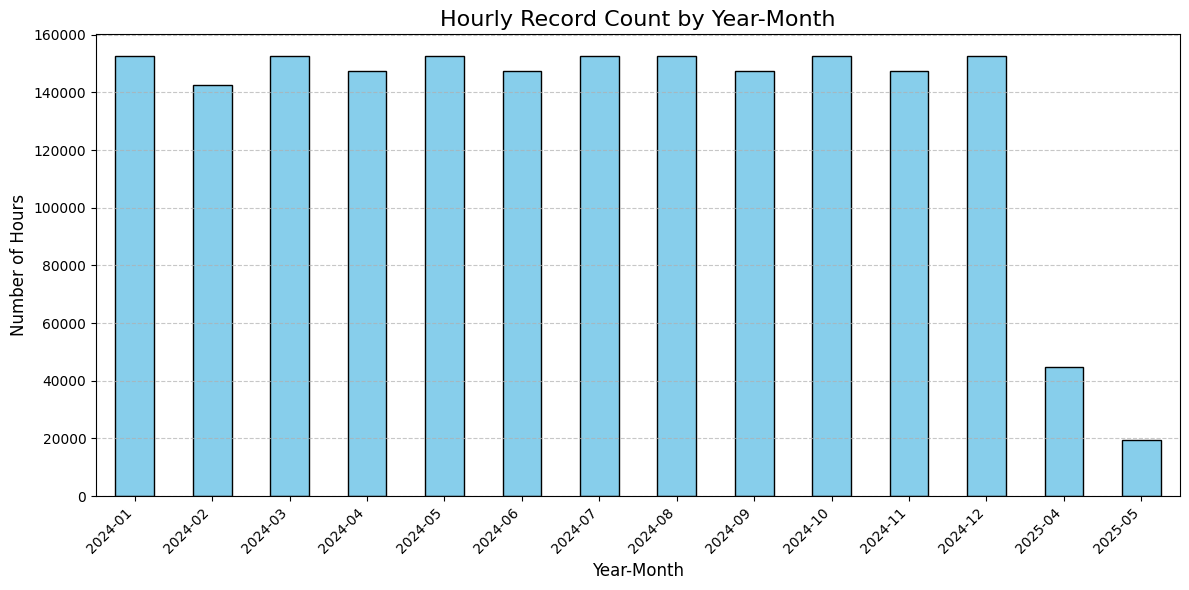

In [17]:
import matplotlib.pyplot as plt

# Group by year_month and count
hour_counts = ts_data.groupby("year_month").size()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))  # Slightly wider for clarity
hour_counts.plot(kind="bar", ax=ax, color="skyblue", edgecolor="black")

# Customizations
ax.set_title("Hourly Record Count by Year-Month", fontsize=16)
ax.set_xlabel("Year-Month", fontsize=12)
ax.set_ylabel("Number of Hours", fontsize=12)
ax.set_xticklabels(hour_counts.index.astype(str), rotation=45, ha="right")
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


In [18]:
ts_data.head()      

,pickup_hour,pickup_location_id,rides,year_month
0,2024-01-01 00:00:00,4074.14,0,2024-01
1,2024-01-01 01:00:00,4074.14,0,2024-01
2,2024-01-01 02:00:00,4074.14,0,2024-01
3,2024-01-01 03:00:00,4074.14,0,2024-01
4,2024-01-01 04:00:00,4074.14,0,2024-01


In [19]:
gte = ts_data["year_month"] >= pd.Period("2024-01", freq="M")
lte = ts_data["year_month"] <= pd.Period("2024-12", freq="M")
cond = gte & lte

filtered_data = ts_data[cond].reset_index(drop=True)

In [20]:
filtered_data.drop(columns=["year_month"], inplace=True) 

In [21]:
filtered_data.shape

(1800720, 3)

In [22]:
ts_data = filtered_data

In [23]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800720 entries, 0 to 1800719
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pickup_hour         datetime64[ns]
 1   pickup_location_id  object        
 2   rides               int32         
dtypes: datetime64[ns](1), int32(1), object(1)
memory usage: 34.3+ MB


In [24]:
ts_data.head()["pickup_hour"].values

array(['2024-01-01T00:00:00.000000000', '2024-01-01T01:00:00.000000000',
       '2024-01-01T02:00:00.000000000', '2024-01-01T03:00:00.000000000',
       '2024-01-01T04:00:00.000000000'], dtype='datetime64[ns]')

In [25]:
from src.data_utils import transform_ts_data_into_features_and_target

features, targets, full_df = transform_ts_data_into_features_and_target(ts_data, window_size=24*28, step_size=23)

#full_df is a combined df

In [26]:
features.sort_values(["pickup_location_id", "pickup_hour"])

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2024-01-29 00:00:00,4074.14
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2024-01-29 23:00:00,4074.14
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2024-01-30 22:00:00,4074.14
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2024-01-31 21:00:00,4074.14
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2024-02-01 20:00:00,4074.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72360,0,2,2,0,1,1,0,1,4,0,...,0,0,0,0,0,1,0,2,2024-12-27 12:00:00,JC116
72361,3,0,5,2,4,5,1,1,1,0,...,0,0,0,0,0,0,0,0,2024-12-28 11:00:00,JC116
72362,0,1,2,0,3,1,0,1,1,1,...,0,0,0,0,0,0,0,2,2024-12-29 10:00:00,JC116
72363,0,0,5,0,5,2,3,4,5,4,...,1,0,0,0,0,0,0,1,2024-12-30 09:00:00,JC116


In [27]:
features[features["pickup_location_id"] == "JC116"]

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
72012,12,2,4,0,0,0,0,0,1,1,...,0,0,0,1,1,2,0,0,2024-01-29 00:00:00,JC116
72013,1,0,0,0,1,0,0,0,0,0,...,3,4,7,3,5,1,0,1,2024-01-29 23:00:00,JC116
72014,1,0,0,0,0,0,0,0,0,1,...,5,3,3,8,6,1,4,2,2024-01-30 22:00:00,JC116
72015,0,1,0,1,0,0,0,0,0,0,...,4,1,1,1,9,7,3,0,2024-01-31 21:00:00,JC116
72016,1,2,3,0,0,0,0,0,1,0,...,2,2,2,0,2,6,5,6,2024-02-01 20:00:00,JC116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72360,0,2,2,0,1,1,0,1,4,0,...,0,0,0,0,0,1,0,2,2024-12-27 12:00:00,JC116
72361,3,0,5,2,4,5,1,1,1,0,...,0,0,0,0,0,0,0,0,2024-12-28 11:00:00,JC116
72362,0,1,2,0,3,1,0,1,1,1,...,0,0,0,0,0,0,0,2,2024-12-29 10:00:00,JC116
72363,0,0,5,0,5,2,3,4,5,4,...,1,0,0,0,0,0,0,1,2024-12-30 09:00:00,JC116


In [28]:
features_copy = features.copy()

In [29]:
features_targets = features.copy()
features_targets["target"] = targets

features_targets.shape

(72365, 675)

In [30]:
from datetime import datetime, timedelta  
import pandas as pd  
from src.data_utils import split_time_series_data  

# Define the cutoff date as 28 days before today  
cutoff_date = pd.Timestamp(datetime.now() - timedelta(days=28))  
# # Convert the cutoff date to a string in a specific format (e.g., 'YYYY-MM-DD')  
# cutoff_date_str = cutoff_date.strftime('%Y-%m-%d')
# # Print the string representation of the cutoff date  
# print(f"Cutoff date as string: {cutoff_date_str}")
cutoff_date

Timestamp('2025-04-11 14:53:24.579079')

In [31]:
X_train, y_train, X_test, y_test = split_time_series_data(
    features_targets,
    cutoff_date=cutoff_date,
    target_column="target"
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(72365, 674)
(72365,)
(0, 674)
(0,)


In [32]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72365 entries, 0 to 72364
Columns: 674 entries, rides_t-672 to pickup_location_id
dtypes: datetime64[ns](1), int64(672), object(1)
memory usage: 372.1+ MB


In [33]:
X_train

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2024-01-29 00:00:00,4074.14
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2024-01-29 23:00:00,4074.14
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2024-01-30 22:00:00,4074.14
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2024-01-31 21:00:00,4074.14
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2024-02-01 20:00:00,4074.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72360,0,2,2,0,1,1,0,1,4,0,...,0,0,0,0,0,1,0,2,2024-12-27 12:00:00,JC116
72361,3,0,5,2,4,5,1,1,1,0,...,0,0,0,0,0,0,0,0,2024-12-28 11:00:00,JC116
72362,0,1,2,0,3,1,0,1,1,1,...,0,0,0,0,0,0,0,2,2024-12-29 10:00:00,JC116
72363,0,0,5,0,5,2,3,4,5,4,...,1,0,0,0,0,0,0,1,2024-12-30 09:00:00,JC116


In [34]:
#To avoid errors during model fitting (LightGBM doesn't handle datetime/object directly)
X_train = X_train.drop(columns=["pickup_hour", "pickup_location_id"])
X_test = X_test.drop(columns=["pickup_hour", "pickup_location_id"])


In [35]:
X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72365 entries, 0 to 72364
Columns: 672 entries, rides_t-672 to rides_t-1
dtypes: int64(672)
memory usage: 371.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Columns: 672 entries, rides_t-672 to rides_t-1
dtypes: int64(672)
memory usage: 132.0 bytes


In [36]:
from src.pipeline_utils import get_pipeline
pipeline = get_pipeline()

In [37]:
pipeline.fit(features, targets)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.219764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22115
[LightGBM] [Info] Number of data points in the train set: 72365, number of used features: 675
[LightGBM] [Info] Start training from score 0.589664


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function average_rides_last_4_weeks at 0x000001DE03C2C220>)),
                ('temporalfeatureengineer', TemporalFeatureEngineer()),
                ('lgbmregressor', LGBMRegressor())])

In [38]:
from sklearn.metrics import mean_absolute_error
predictions = pipeline.predict(features)

In [39]:
predictions

array([1.48508925e-04, 1.48508925e-04, 1.48508925e-04, ...,
       2.49396206e-01, 9.96126294e-01, 2.60629545e-01])

In [40]:
test_mae = mean_absolute_error(targets, predictions)
print(f"Test MAE: {test_mae:.4f}")

Test MAE: 0.3115


In [41]:
import joblib  


# Save the pipeline  
joblib.dump(pipeline, config.MODELS_DIR / "lgb_model.pkl")

['C:\\Users\\divij\\Downloads\\citi_bike_zip\\models\\lgb_model.pkl']

In [42]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(features)
output_schema = Schema(targets)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

In [43]:
model_registry = project.get_model_registry()

model = model_registry.sklearn.create_model(
    name="citi_bike_ride_predictor_next_hour",
    metrics={"test_mae": test_mae},
    description="LightGBM regressor",
    input_example=features.sample(),
    model_schema=model_schema,
    #include_files=["src/", "requirements.txt"]  # Include directories and files
)
# https://community.hopsworks.ai/t/attributeerror-windowspath-object-has-no-attribute-startswith/1003
#model.save(str(config.MODELS_DIR / "lgb_model.pkl"))
model.save('C:\\Users\\divij\\Downloads\\citi_bike_zip\\models\\lgb_model.pkl')

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading C:\Users\divij\Downloads\citi_bike_zip\models\lgb_model.pkl: 0.000%|          | 0/320763 elapsed<00:…

Uploading C:\Users\divij\Downloads\citi_bike_zip\notebooks\input_example.json: 0.000%|          | 0/2050 elaps…

Uploading C:\Users\divij\Downloads\citi_bike_zip\notebooks\model_schema.json: 0.000%|          | 0/51326 elaps…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1215663/models/citi_bike_ride_predictor_next_hour/1


Model(name: 'citi_bike_ride_predictor_next_hour', version: 1)

In [44]:
from src.inference import load_model_from_registry

model = load_model_from_registry()

2025-05-09 14:56:08,984 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-05-09 14:56:09,008 INFO: Initializing external client
2025-05-09 14:56:09,008 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-05-09 14:56:10,517 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1215663


Downloading: 0.000%|          | 0/320763 elapsed<00:00 remaining<?

In [45]:
from src.inference import get_model_predictions

In [46]:
preds = get_model_predictions(model, features_copy)

In [47]:
#model.get_m

In [48]:
preds

,pickup_location_id,pickup_hour,predicted_demand
0,4074.14,2024-01-29 00:00:00,0.0
1,4074.14,2024-01-29 23:00:00,0.0
2,4074.14,2024-01-30 22:00:00,0.0
3,4074.14,2024-01-31 21:00:00,0.0
4,4074.14,2024-02-01 20:00:00,0.0
...,...,...,...
72360,JC116,2024-12-27 12:00:00,2.0
72361,JC116,2024-12-28 11:00:00,1.0
72362,JC116,2024-12-29 10:00:00,0.0
72363,JC116,2024-12-30 09:00:00,1.0


In [49]:
test_mae = mean_absolute_error(targets, preds["predicted_demand"])
print(f"Test MAE: {test_mae:.4f}")

Test MAE: 0.2944
